In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gns_utils import prepare_expr_files, csv_log_to_dataframe, split_dataframe, create_experiment_bash_with

EXPR_DIR = Path("gns_experiments")
CKPT_DIR = Path("checkpoints")
all_models = sorted(os.listdir(CKPT_DIR))
all_models

['0010000.pt', '0020000.pt', '0700000.pt', '0750000.pt']

In [2]:
def compare_estimation_parameters(
        name: str,
        expr_dir: str,
        models: [str],
        Bb_ratio: int,
        reps: int,
        min_size: int,
        max_size: int,
        b_step: int,
    ):
    assert len(models) > 1, "You must specify at least one model!"
    ## Process arguments and create .sh/.csv names
    shell_name, csv_name, vis_dir = prepare_expr_files(expr_name=name, expr_dir=expr_dir)

    ## Create experiment shells
    expr_count = 0
    for model in models:
        ## Check if model exists
        path = f"{CKPT_DIR}/{model}"
        assert os.path.exists(path), f"Checkpoint {path} does not exist!"

        ## Initialize set sizes (smallest)
        b = min_size
        B = Bb_ratio * b

        ## Iterate over batch size values
        while min_size <= b < B <= max_size:
            ## Create experiment with given values
            args = f"-b {b} -B {B} -r {reps}"
            create_experiment_bash_with(args, model, bash_path=shell_name, csv_path=csv_name, vis_dir=vis_dir)
            expr_count += 1
            ## Set new batch size values
            b += b_step
            B = Bb_ratio * b

    print(f"{expr_count} experiments.")
    print(f"Execute in the root-dir using GPUs:")
    print("------------------------------------------\n")

In [3]:
path = EXPR_DIR / "1_true_grad_accuracy/results/"
files = [path / file for file in os.listdir(path)]
df = pd.concat([csv_log_to_dataframe(file, split=True) for file in files])

/Users/egecimsir/Desktop/GenAI Practical/Critical-Multitask-Batch-Sizes-in-Diffusion-Models/gns_utils.py:165: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["runtime"] = pd.to_datetime(df["runtime"])


In [4]:
meta, param, res = split_dataframe(df)
param

,model,t_min,t_max,diff_steps,true_portion
0,0010000.pt,NaN,NaN,1000,0.5
0,0010000.pt,NaN,NaN,1000,0.1
1,0010000.pt,NaN,NaN,1000,0.1
0,0010000.pt,NaN,NaN,1000,0.2


In [5]:
res

,gns_est,g_norm,b_true,t_min,t_max,runtime
0,12.470157,1.033059,25000,NaN,NaN,00:06:17.515130
0,2.799724,"tensor(1.0477, device='cuda:0')",5000,NaN,NaN,00:02:32.160207
1,0.735751,1.0329235792160034,5000,NaN,NaN,00:01:56.101521
0,1.958498,1.032797,10000,NaN,NaN,00:03:02.227157


In [9]:
df = pd.concat([param, res], axis=1).drop(["t_min", "t_max", "diff_steps"], axis=1)
df

,model,true_portion,gns_est,g_norm,b_true,runtime
0,0010000.pt,0.5,12.470157,1.033059,25000,00:06:17.515130
0,0010000.pt,0.1,2.799724,"tensor(1.0477, device='cuda:0')",5000,00:02:32.160207
1,0010000.pt,0.1,0.735751,1.0329235792160034,5000,00:01:56.101521
0,0010000.pt,0.2,1.958498,1.032797,10000,00:03:02.227157


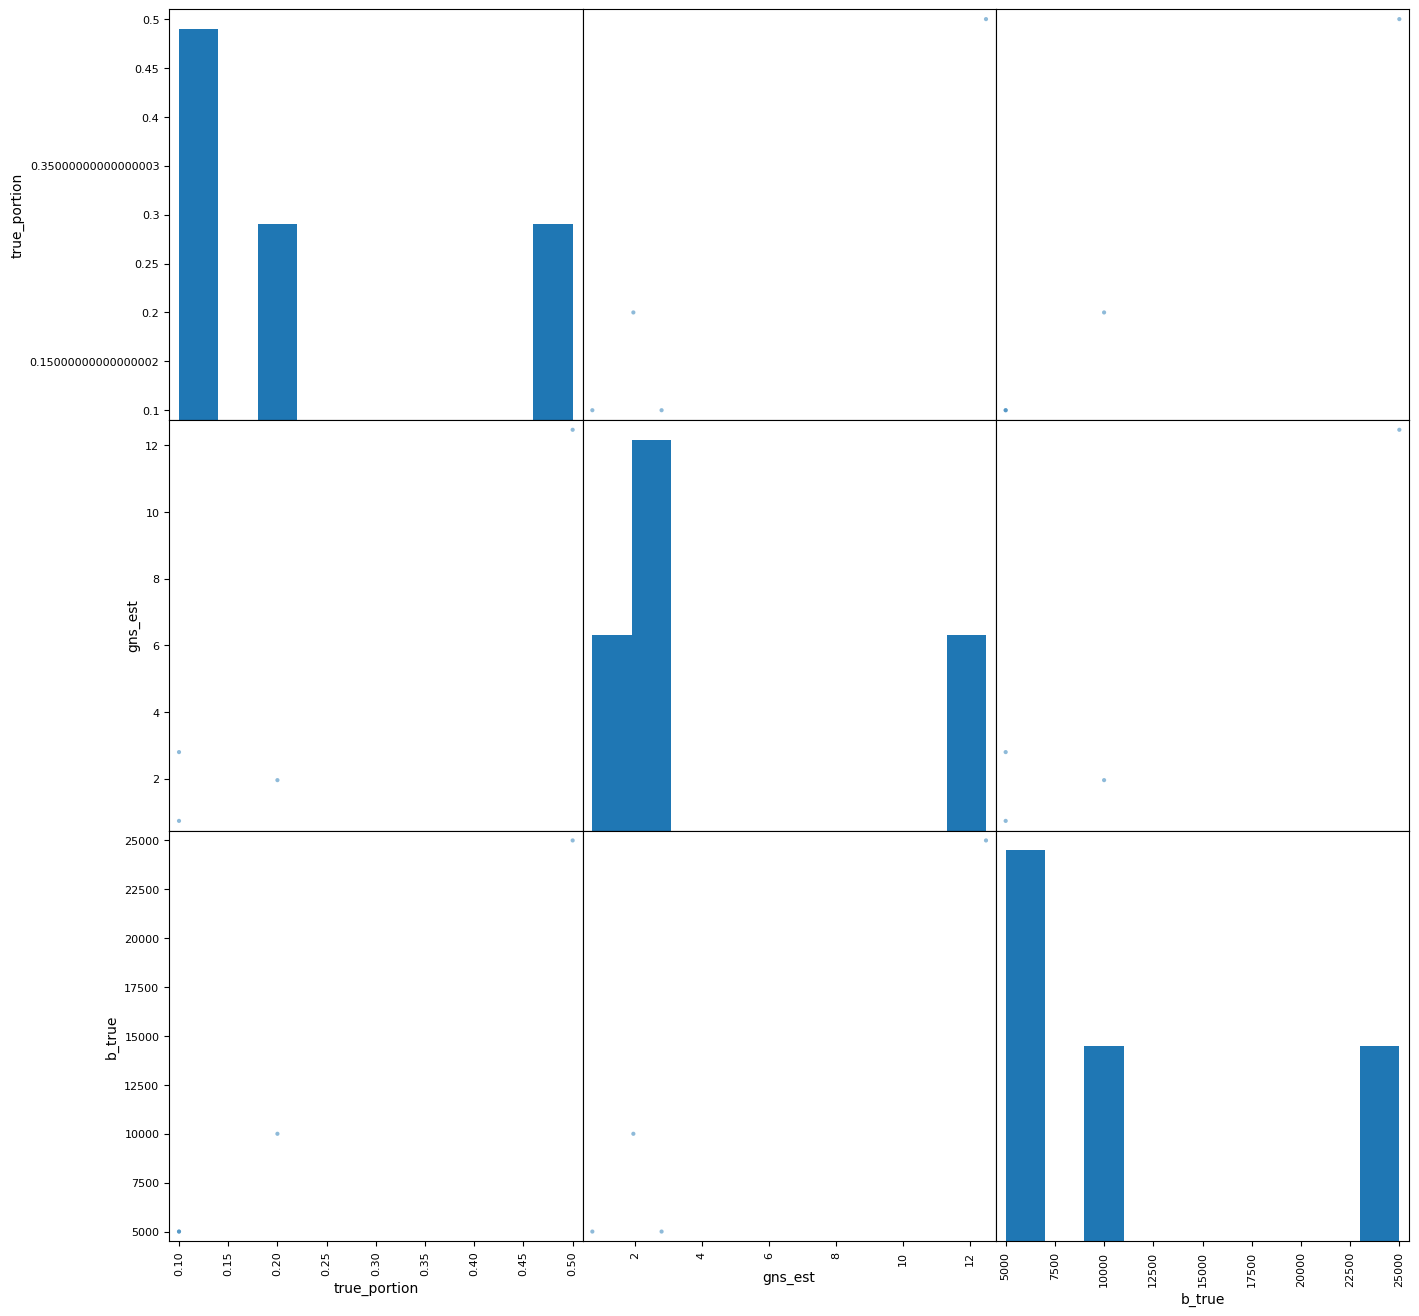

In [7]:
pd.plotting.scatter_matrix(df, figsize=(16, 16))
plt.show()